In [1]:
#Habilitar si usas google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [167]:
import pandas as pd

# Lectura de la data

In [168]:
# Utilizando google colab ruta Jesus
#data = pd.read_csv('/content/drive/MyDrive/IA/PracticaCalificada2-CC421/train.csv', chunksize=42000000)
# Utilizando google colab ruta Franz
#data = pd.read_csv('/content/drive/MyDrive/IA_PC2/train.csv', chunksize=1000000)
# Utilizando google colab ruta Abel
#data = pd.read_csv('/content/drive/MyDrive/IA_PC2/train.csv', chunksize=1000000)
# Utilizando google colab ruta Eros
#data = pd.read_csv('/content/drive/MyDrive/IA-PC2/train.csv', chunksize=1000000 )
# Desde local (jupyter notebook)
data = pd.read_csv('train.csv', chunksize=5000000)

In [169]:
data.get_chunk()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
4999995,2011-01-24 21:33:44.0000003,16.5,2011-01-24 21:33:44 UTC,-74.003883,40.725772,-73.969391,40.800830,1
4999996,2013-10-11 12:12:00.000000118,9.0,2013-10-11 12:12:00 UTC,-73.995105,40.739897,-73.985217,40.731950,2
4999997,2014-12-06 23:04:28.0000002,10.5,2014-12-06 23:04:28 UTC,-73.981063,40.764125,-73.979259,40.781857,2
4999998,2015-05-30 19:01:24.0000004,10.0,2015-05-30 19:01:24 UTC,-73.965401,40.759140,-73.971886,40.750870,1


In [170]:
df = data.get_chunk() 

In [171]:
print(df.head())

                                   key  fare_amount          pickup_datetime  \
5000000  2010-10-05 21:38:00.000000107         8.10  2010-10-05 21:38:00 UTC   
5000001    2012-07-08 01:37:46.0000003         6.10  2012-07-08 01:37:46 UTC   
5000002   2012-12-09 18:03:00.00000057        98.75  2012-12-09 18:03:00 UTC   
5000003    2013-09-27 08:39:12.0000002         7.00  2013-09-27 08:39:12 UTC   
5000004    2010-12-25 00:45:46.0000001         6.50  2010-12-25 00:45:46 UTC   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
5000000        -73.989192        40.756860         -74.010300   
5000001        -73.986931        40.729699         -73.980274   
5000002          0.000000         0.000000           0.000000   
5000003        -73.982050        40.774399         -73.970415   
5000004        -73.921857        40.743345         -73.898194   

         dropoff_latitude  passenger_count  
5000000         40.734488                1  
5000001         40.744413             

# Preprocesamiento de la data

Se cuentan las filas con valores nulos, como estás representan una cantidad infíma
simplemente se eliminarán

In [172]:
print(df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    33
dropoff_latitude     33
passenger_count       0
dtype: int64


In [173]:
df.dropna(inplace = True)
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


Se eliminará las columnas donde el precio sea menor a 0

In [174]:
print(df[df['fare_amount']<0].count())
df.drop(df[df['fare_amount']<0].index, inplace=True)

key                  209
fare_amount          209
pickup_datetime      209
pickup_longitude     209
pickup_latitude      209
dropoff_longitude    209
dropoff_latitude     209
passenger_count      209
dtype: int64


In [175]:
print(df[df['fare_amount']<0].count())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


Se utilizará solo la hora del tiempo de recogo, para ello lo extraemos en otra columna

In [176]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [177]:
df['pickup_hour'] =df['pickup_datetime'].dt.hour

In [178]:
print(df['pickup_hour'])

5000000    21
5000001     1
5000002    18
5000003     8
5000004     0
           ..
9999995     1
9999996    10
9999997     8
9999998    16
9999999    19
Name: pickup_hour, Length: 4999758, dtype: int64


En la columna de números de pasajeros los valores están entre 0-6, existen pocos valores mayores a 7, asi que para que no afecte el modelo se eliminarán

In [179]:
print(df['passenger_count'].value_counts())

1      3458145
2       738228
5       353791
3       219853
6       106082
4       105994
0        17660
208          2
49           1
9            1
7            1
Name: passenger_count, dtype: int64


In [180]:
df.drop(df[df["passenger_count"] >=7].index, inplace=True)

In [181]:
print(df['passenger_count'].value_counts())

1    3458145
2     738228
5     353791
3     219853
6     106082
4     105994
0      17660
Name: passenger_count, dtype: int64


In [182]:
print(df.dtypes)
print(df.head())

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
pickup_hour                   int64
dtype: object
                                   key  fare_amount     pickup_datetime  \
5000000  2010-10-05 21:38:00.000000107         8.10 2010-10-05 21:38:00   
5000001    2012-07-08 01:37:46.0000003         6.10 2012-07-08 01:37:46   
5000002   2012-12-09 18:03:00.00000057        98.75 2012-12-09 18:03:00   
5000003    2013-09-27 08:39:12.0000002         7.00 2013-09-27 08:39:12   
5000004    2010-12-25 00:45:46.0000001         6.50 2010-12-25 00:45:46   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
5000000        -73.989192        40.756860         -74.010300   
5000001        -73.986931        40.729699         -73.980274   
5000002         

In [183]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour
5000000,2010-10-05 21:38:00.000000107,8.10,2010-10-05 21:38:00,-73.989192,40.756860,-74.010300,40.734488,1,21
5000001,2012-07-08 01:37:46.0000003,6.10,2012-07-08 01:37:46,-73.986931,40.729699,-73.980274,40.744413,2,1
5000002,2012-12-09 18:03:00.00000057,98.75,2012-12-09 18:03:00,0.000000,0.000000,0.000000,0.000000,5,18
5000003,2013-09-27 08:39:12.0000002,7.00,2013-09-27 08:39:12,-73.982050,40.774399,-73.970415,40.783874,1,8
5000004,2010-12-25 00:45:46.0000001,6.50,2010-12-25 00:45:46,-73.921857,40.743345,-73.898194,40.743277,1,0


###Creando columna de distancia recorrida

Hallaremos la distancia recorrida en km para cada fila. \\
Usamos la Haversine formula, que halla la distancia entre dos puntos en una esfera dadas sus longitudes y latitudes. \\
$d = 2r \arcsin (\sqrt{\sin^{2}(\frac{\varphi_2 - \varphi_1}{2}) + \cos(\varphi_1)cos(\varphi_2)\sin^{2}(\frac{\lambda_2 - \lambda_1}{2})})$ \\
Sea $\varphi_1, \varphi_2$ latitudes y $\lambda_1, \lambda_2$ longitudes \\
referencia: https://en.wikipedia.org/wiki/Haversine_formula

Para disminuir los cálculos, lo llevaremos a ángulo doble: $\sin^{2}(\frac{\varphi_2 - \varphi_1}{2}) = \frac{1-\cos(\varphi_2 - \varphi_1)}{2}$

In [184]:
from math import cos, asin, sqrt, pi
p = pi/180
radioTierra = 6371
df["distancia_recorrida"] = df.apply(
    lambda fila: 2*radioTierra * asin(sqrt(0.5 - cos((fila.dropoff_latitude - fila.pickup_latitude) * p)/2 + cos(fila.pickup_latitude * p) * cos(fila.dropoff_latitude * p) * (1 - cos((fila.dropoff_longitude - fila.pickup_longitude) * p)) / 2)) 
, axis=1)

In [185]:
df.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida
5000000,2010-10-05 21:38:00.000000107,8.10,2010-10-05 21:38:00,-73.989192,40.756860,-74.010300,40.734488,1,21,3.057843
5000001,2012-07-08 01:37:46.0000003,6.10,2012-07-08 01:37:46,-73.986931,40.729699,-73.980274,40.744413,2,1,1.729589
5000002,2012-12-09 18:03:00.00000057,98.75,2012-12-09 18:03:00,0.000000,0.000000,0.000000,0.000000,5,18,0.000000
5000003,2013-09-27 08:39:12.0000002,7.00,2013-09-27 08:39:12,-73.982050,40.774399,-73.970415,40.783874,1,8,1.438670
5000004,2010-12-25 00:45:46.0000001,6.50,2010-12-25 00:45:46,-73.921857,40.743345,-73.898194,40.743277,1,0,1.993524
5000005,2011-10-24 19:35:22.0000006,9.70,2011-10-24 19:35:22,-73.984459,40.764714,-73.972782,40.795747,1,19,3.588047
5000006,2009-10-15 07:17:59.0000001,6.10,2009-10-15 07:17:59,-73.982457,40.765540,-73.982457,40.765540,1,7,0.000000
5000007,2010-06-13 00:42:00.000000176,11.30,2010-06-13 00:42:00,-73.979030,40.740738,-73.954483,40.783950,1,0,5.230841
5000008,2010-06-14 21:57:00.000000137,22.10,2010-06-14 21:57:00,-74.005115,40.719457,-73.942488,40.786262,1,21,9.110963
5000009,2014-01-25 11:24:30.0000001,9.00,2014-01-25 11:24:30,-73.977733,40.733655,-73.996090,40.726272,1,11,1.751168


Eliminamos valores raros, donde la distancia no va acorde con la tarifa

In [186]:
import numpy as np
##Se crea una nueva columna con valores "ok" y "no"
df["booleano"]= np.where((df["distancia_recorrida"]>100)& (df["fare_amount"]<20),'no','ok')


In [187]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida,booleano
5000000,2010-10-05 21:38:00.000000107,8.10,2010-10-05 21:38:00,-73.989192,40.756860,-74.010300,40.734488,1,21,3.057843,ok
5000001,2012-07-08 01:37:46.0000003,6.10,2012-07-08 01:37:46,-73.986931,40.729699,-73.980274,40.744413,2,1,1.729589,ok
5000002,2012-12-09 18:03:00.00000057,98.75,2012-12-09 18:03:00,0.000000,0.000000,0.000000,0.000000,5,18,0.000000,ok
5000003,2013-09-27 08:39:12.0000002,7.00,2013-09-27 08:39:12,-73.982050,40.774399,-73.970415,40.783874,1,8,1.438670,ok
5000004,2010-12-25 00:45:46.0000001,6.50,2010-12-25 00:45:46,-73.921857,40.743345,-73.898194,40.743277,1,0,1.993524,ok
...,...,...,...,...,...,...,...,...,...,...,...
9999995,2012-08-12 01:18:00.000000208,5.70,2012-08-12 01:18:00,-73.999464,40.728452,-73.993299,40.742100,2,1,1.604023,ok
9999996,2013-08-07 10:28:00.000000147,5.50,2013-08-07 10:28:00,-73.968467,40.759367,-73.964967,40.769027,1,10,1.113854,ok
9999997,2013-10-29 08:29:00.00000082,14.00,2013-10-29 08:29:00,-73.997952,40.733717,-73.973448,40.759122,5,8,3.498755,ok
9999998,2012-04-07 16:41:33.0000004,10.50,2012-04-07 16:41:33,-73.992700,40.752021,-73.964705,40.772849,1,16,3.304974,ok


In [188]:
#eliminamos todas las filas que tengan "no"
indices = df[df['booleano']=='no'].index
df.drop(indices, inplace=True)

In [189]:
#eliminamos la columna booleano
df.drop(columns=["booleano"], inplace=True)
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida
5000000,2010-10-05 21:38:00.000000107,8.10,2010-10-05 21:38:00,-73.989192,40.756860,-74.010300,40.734488,1,21,3.057843
5000001,2012-07-08 01:37:46.0000003,6.10,2012-07-08 01:37:46,-73.986931,40.729699,-73.980274,40.744413,2,1,1.729589
5000002,2012-12-09 18:03:00.00000057,98.75,2012-12-09 18:03:00,0.000000,0.000000,0.000000,0.000000,5,18,0.000000
5000003,2013-09-27 08:39:12.0000002,7.00,2013-09-27 08:39:12,-73.982050,40.774399,-73.970415,40.783874,1,8,1.438670
5000004,2010-12-25 00:45:46.0000001,6.50,2010-12-25 00:45:46,-73.921857,40.743345,-73.898194,40.743277,1,0,1.993524
...,...,...,...,...,...,...,...,...,...,...
9999995,2012-08-12 01:18:00.000000208,5.70,2012-08-12 01:18:00,-73.999464,40.728452,-73.993299,40.742100,2,1,1.604023
9999996,2013-08-07 10:28:00.000000147,5.50,2013-08-07 10:28:00,-73.968467,40.759367,-73.964967,40.769027,1,10,1.113854
9999997,2013-10-29 08:29:00.00000082,14.00,2013-10-29 08:29:00,-73.997952,40.733717,-73.973448,40.759122,5,8,3.498755
9999998,2012-04-07 16:41:33.0000004,10.50,2012-04-07 16:41:33,-73.992700,40.752021,-73.964705,40.772849,1,16,3.304974


#Usando algoritmos y entrenando

Se usarán las siguientes carácteristicas


In [190]:
X = df[['passenger_count','pickup_hour','distancia_recorrida']]
y = df.fare_amount
print(X)

         passenger_count  pickup_hour  distancia_recorrida
5000000                1           21             3.057843
5000001                2            1             1.729589
5000002                5           18             0.000000
5000003                1            8             1.438670
5000004                1            0             1.993524
...                  ...          ...                  ...
9999995                2            1             1.604023
9999996                1           10             1.113854
9999997                5            8             3.498755
9999998                1           16             3.304974
9999999                1           19             2.885319

[4990595 rows x 3 columns]


In [191]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)

In [192]:
print(X)

[[ 0.          0.7         0.35753342]
 [ 1.         -1.3        -0.14452757]
 [ 4.          0.4        -0.79828751]
 ...
 [ 4.         -0.6         0.52419163]
 [ 0.          0.2         0.45094534]
 [ 0.          0.5         0.29232165]]


In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [194]:
from sklearn.tree import DecisionTreeRegressor
regressor1 = DecisionTreeRegressor(random_state=0)
regressor2 = DecisionTreeRegressor(random_state=0, max_depth=11,
                                   max_features='auto',
                                   splitter='best')

a1 = regressor1.fit(X_train,y_train)
a2 = regressor2.fit(X_train,y_train)

y1=a1.predict(X_test)
y2=a2.predict(X_test)

In [195]:
print(regressor1)
print()
print(regressor2)

DecisionTreeRegressor(random_state=0)

DecisionTreeRegressor(max_depth=11, max_features='auto', random_state=0)


In [196]:
print("Costo de viaje de los datos de prueba")
print(y_test)
print()

print("Predicciones de costos de viaje")
print("Primer modelo")
print(y1)
print("Segundo modelo")
print(y2)

Costo de viaje de los datos de prueba
7810334    25.7
7267507    18.0
8045206    10.5
7068075     8.1
8645690    14.0
           ... 
5184831    44.1
5817018     8.5
8791850     9.0
8045965     8.1
7171954    29.5
Name: fare_amount, Length: 1497179, dtype: float64

Predicciones de costos de viaje
Primer modelo
[37.45 10.1   6.1  ...  5.3  13.3   8.1 ]
Segundo modelo
[33.5434619  15.28559248  8.39688726 ...  7.19090659  9.69274889
 12.82042034]


#Graficas de las predicciones de precios

In [197]:
import matplotlib.pyplot as plt

#Grafica de la primera prediccion

> 



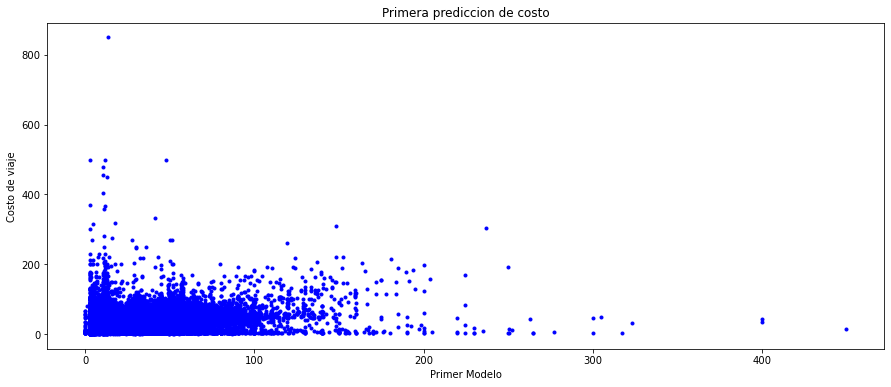

In [198]:
plt.figure(figsize=(15,6))

x_1 = y1 
y_1 = y_test


plt.scatter(x_1 , y_1 , marker='.', color='b')
plt.xlabel("Primer Modelo")
plt.ylabel("Costo de viaje")
plt.title("Primera prediccion de costo")
plt.show()

##Grafica de la segunda prediccion

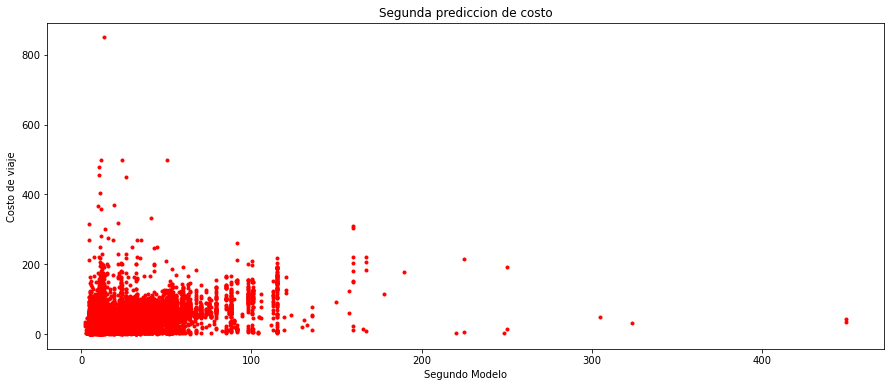

In [199]:
plt.figure(figsize=(15,6))

x_2 = y2 
y_2 = y_test

plt.scatter(x_2 , y_2 , marker='.', color='r')
plt.xlabel("Segundo Modelo")
plt.ylabel("Costo de viaje")
plt.title("Segunda prediccion de costo")
plt.show()

#Comparación

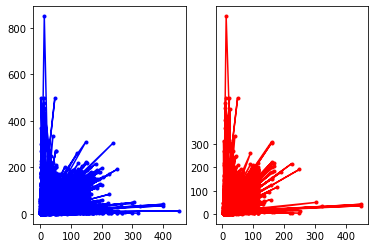

In [200]:
fig, ax = plt.subplots(1,2)

ax[0].plot(x_1 ,y_1 , marker='.' ,color ='b')
plt.yticks([0,100,200,300])

ax[1].plot(x_2 ,y_2 , marker='.',color ='r')
plt.yticks([0,100,200,300])
plt.show()


# Metricas del modelo

**Error absoluto medio (MAE)** 

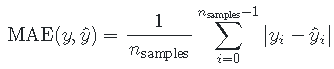

In [201]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y1))
print(mean_absolute_error(y_test, y2))

3.344124906179551
2.411360922837528


**Error cuadrático medio**

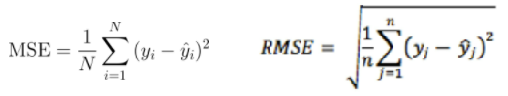

In [202]:
from sklearn.metrics import mean_squared_error

#MSE
print("MSE")
print(mean_squared_error(y_test, y1))
print(mean_squared_error(y_test, y2))

print()

#RMSE
print("RMSE")
print(mean_squared_error(y_test, y1,squared=False))
print(mean_squared_error(y_test, y2,squared=False))


MSE
46.378632501908896
26.83827333463928

RMSE
6.810185937396195
5.180566893172916


**Error máximo**

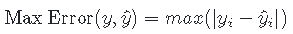

In [203]:
from sklearn.metrics import max_error

print(max_error(y_test, y1))
print(max_error(y_test, y2))

836.8253030303031
836.8253030303031


**Error absoluto mediano**

ErrorAbsolutoMediano.png

In [204]:
from sklearn.metrics import median_absolute_error

print(median_absolute_error(y_test, y1))
print(median_absolute_error(y_test, y2))

1.9000000000000004
1.3861231152796343


**Puntuación de varianza explicada**

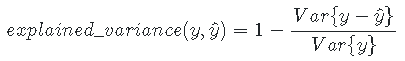

In [205]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(y_test, y1))
print(explained_variance_score(y_test, y2))

0.5214919425448333
0.7230963588435686


**Puntuación R²**

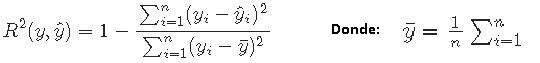

In [206]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y1))
print(r2_score(y_test, y2))

0.5214871660497804
0.7230953665751083


**Error porcentual absoluto medio**

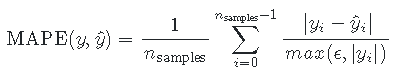

**Desviación media de Tweedie**

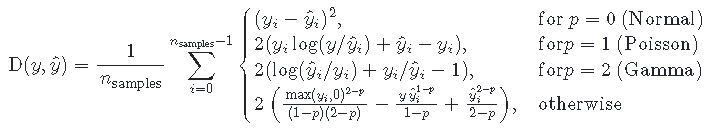

OBS: Para la desviación media de Poisson y Gamma, la variable de prueba y la de predicción deben tener elementos extrictamente positivos.